# Dataset
***Using Fashion Mnist Official dataset ( by tensorflow ) in this notebook***

**You can download that in [this](https://www.kaggle.com/datasets/zalando-research/fashionmnist) kaggle link.**

**or use [this](https://github.com/zalandoresearch/fashion-mnist) github link**

> This notebook is about classifing these clothes:




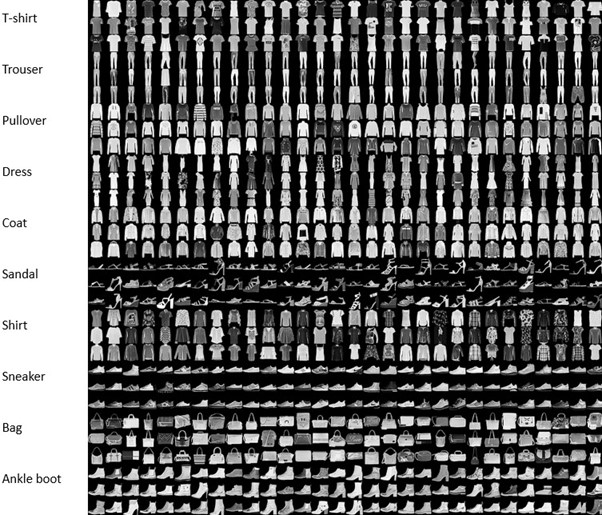



# Imports

## Importing os for training on gpu

In [2]:
import os

( Google colab added this cell to my code )

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## installing keras if you didn't

In [ ]:
!pip install keras

## Importing Libraries we are going to use

In [4]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
from keras.models import Model
from keras.optimizers import RMSprop, Adadelta, SGD, Adam
from keras.layers import Input, Dense, Flatten, Dropout, Concatenate, Reshape, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import BatchNormalization
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical

# Extract Functions

## Defining Extract data function for dataset extraction

In [5]:
def extract_data(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(28 * 28 * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, 28,28)
        return data

## Extracting data

In [6]:
train_data = extract_data('/content/drive/MyDrive/Fashion-Mnist-Clothes/train-images-idx3-ubyte.gz', 60000)
test_data = extract_data('/content/drive/MyDrive/Fashion-Mnist-Clothes/t10k-images-idx3-ubyte.gz', 10000)

## Defining Extract labels function

In [7]:
def extract_labels(fname, num_images):
    with gzip.open(fname) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        return labels

## Extracting labels

In [8]:
train_labels = extract_labels('/content/drive/MyDrive/Fashion-Mnist-Clothes/train-labels-idx1-ubyte.gz',60000)
test_labels = extract_labels('/content/drive/MyDrive/Fashion-Mnist-Clothes/t10k-labels-idx1-ubyte.gz',10000)

# Printing data shape
which should be

*   Training set (images) shape: (60000, 28, 28)
*   Test set (images) shape: (10000, 28, 28)

In [9]:
print("training set shape: {shape}".format(shape=train_data.shape))
print("test set shape: {shape}".format(shape=test_data.shape))

training set shape: (60000, 28, 28)
test set shape: (10000, 28, 28)


# Creating a Label Dictionary for Classes

In [10]:
label_dict = {
 0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'J',
}

## Example usage of label_dict dictionary ( Matplotlib )

Text(0.5, 1.0, '(Label: E)')

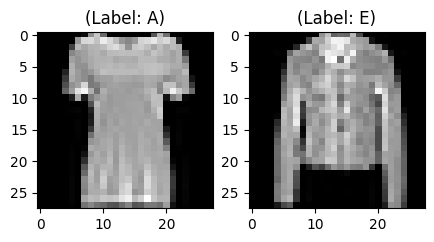

In [11]:
plt.figure(figsize=[5,5])

plt.subplot(121)
curr_img = np.reshape(train_data[10], (28,28))
curr_lbl = train_labels[10]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

plt.subplot(122)
curr_img = np.reshape(test_data[10], (28,28))
curr_lbl = test_labels[10]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")


# Data Preprocessing

## Data Dimensions

 pixel values range from 0 to 255 with 28x28 dimension so we turn in into a 28x28x1 data so we can train our model

In [12]:
train_data = train_data.reshape(-1, 28,28, 1)
test_data = test_data.reshape(-1, 28,28, 1)
train_data.shape, test_data.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

## float32 Converting / Checking

The data is already converted into float32 format while reading so we're just checking here

In [13]:
train_data.dtype, test_data.dtype

(dtype('float32'), dtype('float32'))

## Rescaling Data

rescaling the training and testing data with their maximum pixel value

In [14]:
np.max(train_data), np.max(test_data)

(255.0, 255.0)

In [15]:
train_data = train_data / np.max(train_data)
test_data = test_data / np.max(test_data)

Just Checking

In [16]:
np.max(train_data), np.max(test_data)

(1.0, 1.0)

## Train-Test Split
I considered 20% for test and 80% for training

In [17]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(train_data, train_data, test_size=0.2, random_state=13)

# Convolutional AE

In [18]:
batch_size = 64
epochs = 50
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))
num_classes = 10

## Encoder

input = 28 x 28 x 1 (wide and thin)

In [20]:
def encoder(input_img):
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

## Decoder

In [21]:
def decoder(conv4):
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) #7 x 7 x 128
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5) #7 x 7 x 64
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6) #14 x 14 x 64
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 32
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7) # 28 x 28 x 32
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

## Creating the Model

In [22]:
autoencoder = Model(input_img, decoder(encoder(input_img)))

## Compiling the Model
using RMSprop as Optimizer

In [23]:
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

## Layers Visualization

In [24]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 28, 28, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 28, 28, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0     

# Model Training

## GPU
Before Training the model we should check if the gpu is online

In [25]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "0"

In [ ]:
!nvidia-smi

## Model Fit

In [26]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))

Epoch 1/50
750/750 [==============================] - 23s 17ms/step - loss: 0.0180 - val_loss: 0.0114
Epoch 2/50
750/750 [==============================] - 11s 15ms/step - loss: 0.0097 - val_loss: 0.0083
Epoch 3/50
750/750 [==============================] - 11s 15ms/step - loss: 0.0086 - val_loss: 0.0073
Epoch 4/50
750/750 [==============================] - 12s 15ms/step - loss: 0.0073 - val_loss: 0.0090
Epoch 5/50
750/750 [==============================] - 12s 15ms/step - loss: 0.0067 - val_loss: 0.0059
Epoch 6/50
750/750 [==============================] - 12s 15ms/step - loss: 0.0062 - val_loss: 0.0058
Epoch 7/50
750/750 [==============================] - 12s 16ms/step - loss: 0.0059 - val_loss: 0.0054
Epoch 8/50
750/750 [==============================] - 12s 16ms/step - loss: 0.0056 - val_loss: 0.0057
Epoch 9/50
750/750 [==============================] - 12s 16ms/step - loss: 0.0054 - val_loss: 0.0050
Epoch 10/50
750/750 [==============================] - 12s 16ms/step - loss: 0.005

## Visualizing the model performance

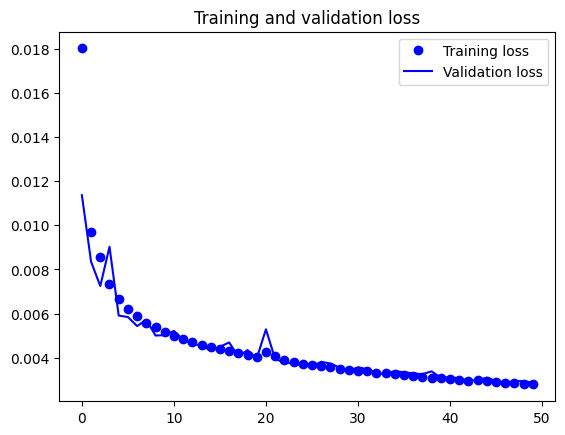

In [27]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(50)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Saving the trained Model

In [28]:
autoencoder.save_weights('autoencoder.h5')

# Segmentation

## Changing lables from categorical to one hot encoding vectors

I will use to_categorical() function to change my labels

In [29]:
train_Y_one_hot = to_categorical(train_labels)
test_Y_one_hot = to_categorical(test_labels)

In [30]:
print('previous:', train_labels[0])
print('after:', train_Y_one_hot[0])

previous: 9
after: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


## Train-Test Split
I'm going to use the same random state I used

In [31]:
train_X,valid_X,train_label,valid_label = train_test_split(train_data,train_Y_one_hot,test_size=0.2,random_state=13)

## Training and Validation set shapes

In [32]:
train_X.shape,valid_X.shape,train_label.shape,valid_label.shape

((48000, 28, 28, 1), (12000, 28, 28, 1), (48000, 10), (12000, 10))

## Encoder

In [33]:
def encoder(input_img):
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

## Fully Connectet Layers


In [34]:
def fc(enco):
    flat = Flatten()(enco)
    den = Dense(128, activation='relu')(flat)
    out = Dense(num_classes, activation='softmax')(den)
    return out

In [35]:
encode = encoder(input_img)
full_model = Model(input_img,fc(encode))

In [36]:
for l1,l2 in zip(full_model.layers[:19],autoencoder.layers[0:19]):
    l1.set_weights(l2.get_weights())

## Get First layer Weights for both models

### First

In [37]:
autoencoder.get_weights()[0][1]

array([[[-3.03599592e-02,  8.42761099e-02, -2.06605434e-01,
         -3.99153605e-02, -1.38608411e-01,  1.45613670e-01,
         -4.64797653e-02,  1.11267634e-01,  1.27088800e-01,
         -3.46430689e-02, -8.28198120e-02, -1.09321535e-01,
         -2.49045324e-02,  5.32849431e-02, -9.62019805e-03,
         -7.12997615e-02, -5.86207537e-03,  2.47326046e-01,
          1.22916423e-01, -5.85634485e-02, -3.80855016e-02,
          9.16800871e-02, -1.46872774e-01,  1.23154223e-01,
         -4.42257896e-03,  5.73668033e-02,  2.14131981e-01,
         -1.21897064e-01, -1.01689972e-01, -5.19721061e-02,
         -9.76377875e-02,  1.88063666e-01]],

       [[-8.68594646e-02,  2.51965255e-01,  7.46259419e-03,
          2.11308338e-02, -1.25300381e-02,  1.14725381e-01,
         -1.22051917e-01, -2.86058057e-03, -1.22383431e-01,
         -3.98960002e-02,  2.27976575e-01,  4.33583697e-03,
         -1.18714117e-01,  9.56131741e-02, -7.57547393e-02,
          2.12244585e-01, -1.71484679e-01,  8.55012089

### Second

In [38]:
full_model.get_weights()[0][1]

array([[[-3.03599592e-02,  8.42761099e-02, -2.06605434e-01,
         -3.99153605e-02, -1.38608411e-01,  1.45613670e-01,
         -4.64797653e-02,  1.11267634e-01,  1.27088800e-01,
         -3.46430689e-02, -8.28198120e-02, -1.09321535e-01,
         -2.49045324e-02,  5.32849431e-02, -9.62019805e-03,
         -7.12997615e-02, -5.86207537e-03,  2.47326046e-01,
          1.22916423e-01, -5.85634485e-02, -3.80855016e-02,
          9.16800871e-02, -1.46872774e-01,  1.23154223e-01,
         -4.42257896e-03,  5.73668033e-02,  2.14131981e-01,
         -1.21897064e-01, -1.01689972e-01, -5.19721061e-02,
         -9.76377875e-02,  1.88063666e-01]],

       [[-8.68594646e-02,  2.51965255e-01,  7.46259419e-03,
          2.11308338e-02, -1.25300381e-02,  1.14725381e-01,
         -1.22051917e-01, -2.86058057e-03, -1.22383431e-01,
         -3.98960002e-02,  2.27976575e-01,  4.33583697e-03,
         -1.18714117e-01,  9.56131741e-02, -7.57547393e-02,
          2.12244585e-01, -1.71484679e-01,  8.55012089

## Don't Need to train first 19 Layers
just training the FC part
Since the encoder part is already trained

In [39]:
for layer in full_model.layers[0:19]:
    layer.trainable = False

## Model Compiling

In [40]:
full_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

## Model Summary

In [41]:
full_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_14 (Ba  (None, 28, 28, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_16 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_15 (Ba  (None, 28, 28, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 32)        0   

# Model Training

## Model Fit

In [42]:
classify_train = full_model.fit(train_X, train_label, batch_size=64,epochs=50,verbose=1,validation_data=(valid_X, valid_label))

Epoch 1/50
750/750 [==============================] - 6s 6ms/step - loss: 0.4338 - accuracy: 0.8591 - val_loss: 0.3216 - val_accuracy: 0.8877
Epoch 2/50
750/750 [==============================] - 4s 6ms/step - loss: 0.2777 - accuracy: 0.8980 - val_loss: 0.3052 - val_accuracy: 0.8922
Epoch 3/50
750/750 [==============================] - 6s 7ms/step - loss: 0.2414 - accuracy: 0.9100 - val_loss: 0.2962 - val_accuracy: 0.8963
Epoch 4/50
750/750 [==============================] - 5s 6ms/step - loss: 0.2227 - accuracy: 0.9185 - val_loss: 0.3090 - val_accuracy: 0.8972
Epoch 5/50
750/750 [==============================] - 5s 6ms/step - loss: 0.2056 - accuracy: 0.9239 - val_loss: 0.3062 - val_accuracy: 0.8934
Epoch 6/50
750/750 [==============================] - 5s 7ms/step - loss: 0.1926 - accuracy: 0.9291 - val_loss: 0.2946 - val_accuracy: 0.9019
Epoch 7/50
750/750 [==============================] - 4s 6ms/step - loss: 0.1794 - accuracy: 0.9332 - val_loss: 0.2854 - val_accuracy: 0.9058
Epoch 

## Saving the trained Model

In [43]:
full_model.save_weights('autoencoder_classification.h5')

# Re-Training the model with the first 19 Layers Trainable
Cause we made'em False before training

In [44]:
for layer in full_model.layers[0:19]:
    layer.trainable = True

## Model Compile

In [45]:
full_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

## Model Fit

In [46]:
classify_train = full_model.fit(train_X, train_label, batch_size=64,epochs=50,verbose=1,validation_data=(valid_X, valid_label))

Epoch 1/50
750/750 [==============================] - 15s 14ms/step - loss: 0.5430 - accuracy: 0.8337 - val_loss: 0.4167 - val_accuracy: 0.8641
Epoch 2/50
750/750 [==============================] - 9s 12ms/step - loss: 0.3081 - accuracy: 0.8922 - val_loss: 0.3778 - val_accuracy: 0.8838
Epoch 3/50
750/750 [==============================] - 9s 13ms/step - loss: 0.2800 - accuracy: 0.9036 - val_loss: 0.3536 - val_accuracy: 0.8873
Epoch 4/50
750/750 [==============================] - 9s 12ms/step - loss: 0.2366 - accuracy: 0.9161 - val_loss: 0.2762 - val_accuracy: 0.9111
Epoch 5/50
750/750 [==============================] - 9s 12ms/step - loss: 0.2074 - accuracy: 0.9256 - val_loss: 0.2686 - val_accuracy: 0.9097
Epoch 6/50
750/750 [==============================] - 9s 12ms/step - loss: 0.1851 - accuracy: 0.9326 - val_loss: 0.2698 - val_accuracy: 0.9134
Epoch 7/50
750/750 [==============================] - 10s 13ms/step - loss: 0.1661 - accuracy: 0.9409 - val_loss: 0.2958 - val_accuracy: 0.90

## Saving the trained Model

In [47]:
full_model.save_weights('classification_complete.h5')

## Visualizing the model performance

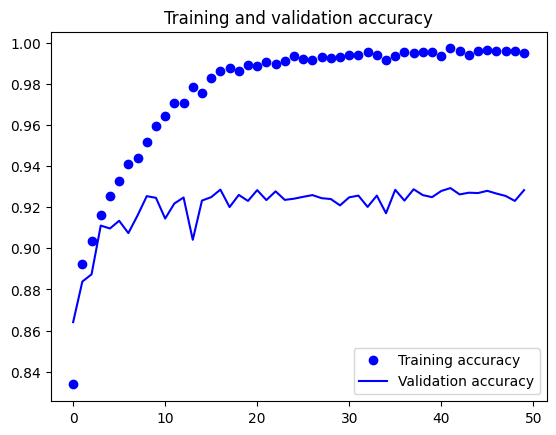

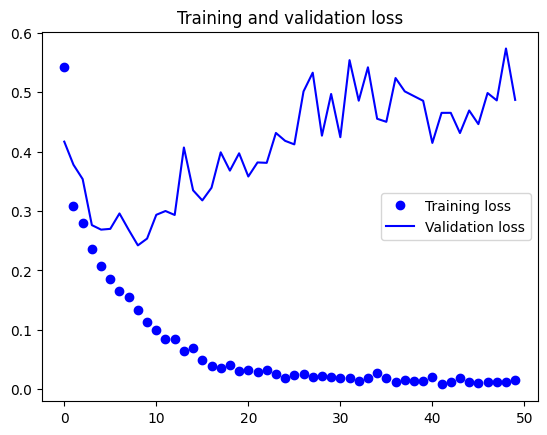

In [48]:
accuracy = classify_train.history['accuracy']
val_accuracy = classify_train.history['val_accuracy']
loss = classify_train.history['loss']
val_loss = classify_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Model Evaluation

on test data

In [49]:
test_eval = full_model.evaluate(test_data, test_Y_one_hot, verbose=0)

In [50]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.49206504225730896
Test accuracy: 0.9232000112533569


# Predict Labels

In [51]:
predicted_classes = full_model.predict(test_data)

313/313 [==============================] - 1s 3ms/step


In [52]:
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)

In [53]:
predicted_classes.shape, test_labels.shape

((10000,), (10000,))

## Visualize the Correct Labels Predicted

Found 9225 correct labels


<ipython-input-54-e473e43f96bd>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,3,i+1)


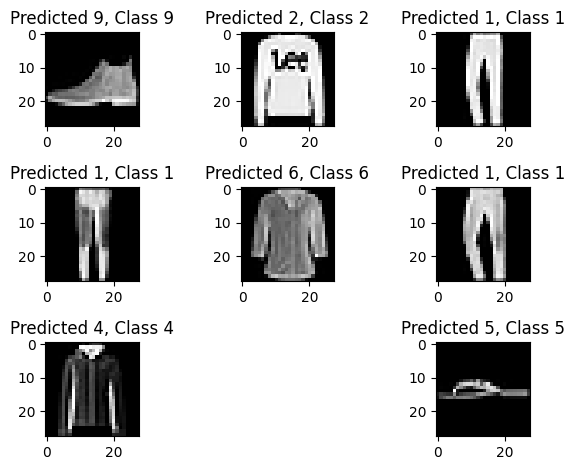

In [54]:
correct = np.where(predicted_classes==test_labels)[0]
print("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_data[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], test_labels[correct]))
    plt.tight_layout()

## Visualize the Incorrect Labels Predicted

Found 775 incorrect labels


<ipython-input-55-28c5a1741c6d>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,3,i+1)


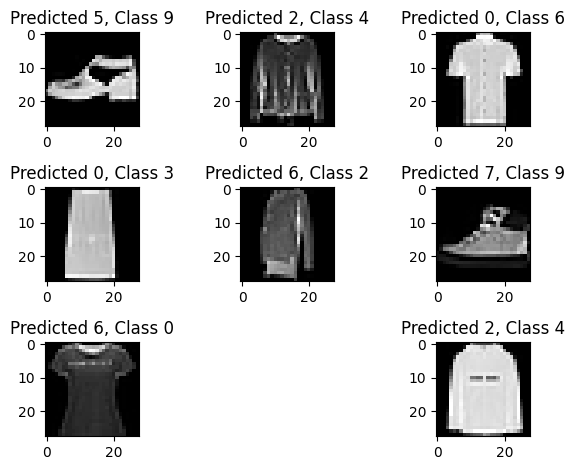

In [55]:
incorrect = np.where(predicted_classes!=test_labels)[0]
print("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_data[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], test_labels[incorrect]))
    plt.tight_layout()

## Classification Report

In [56]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(test_labels, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.82      0.92      0.87      1000
     Class 1       1.00      0.98      0.99      1000
     Class 2       0.86      0.92      0.89      1000
     Class 3       0.94      0.91      0.92      1000
     Class 4       0.87      0.90      0.88      1000
     Class 5       0.99      0.98      0.99      1000
     Class 6       0.84      0.69      0.76      1000
     Class 7       0.95      0.98      0.96      1000
     Class 8       0.99      0.98      0.98      1000
     Class 9       0.98      0.96      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



1/1 [==============================] - 0s 18ms/step


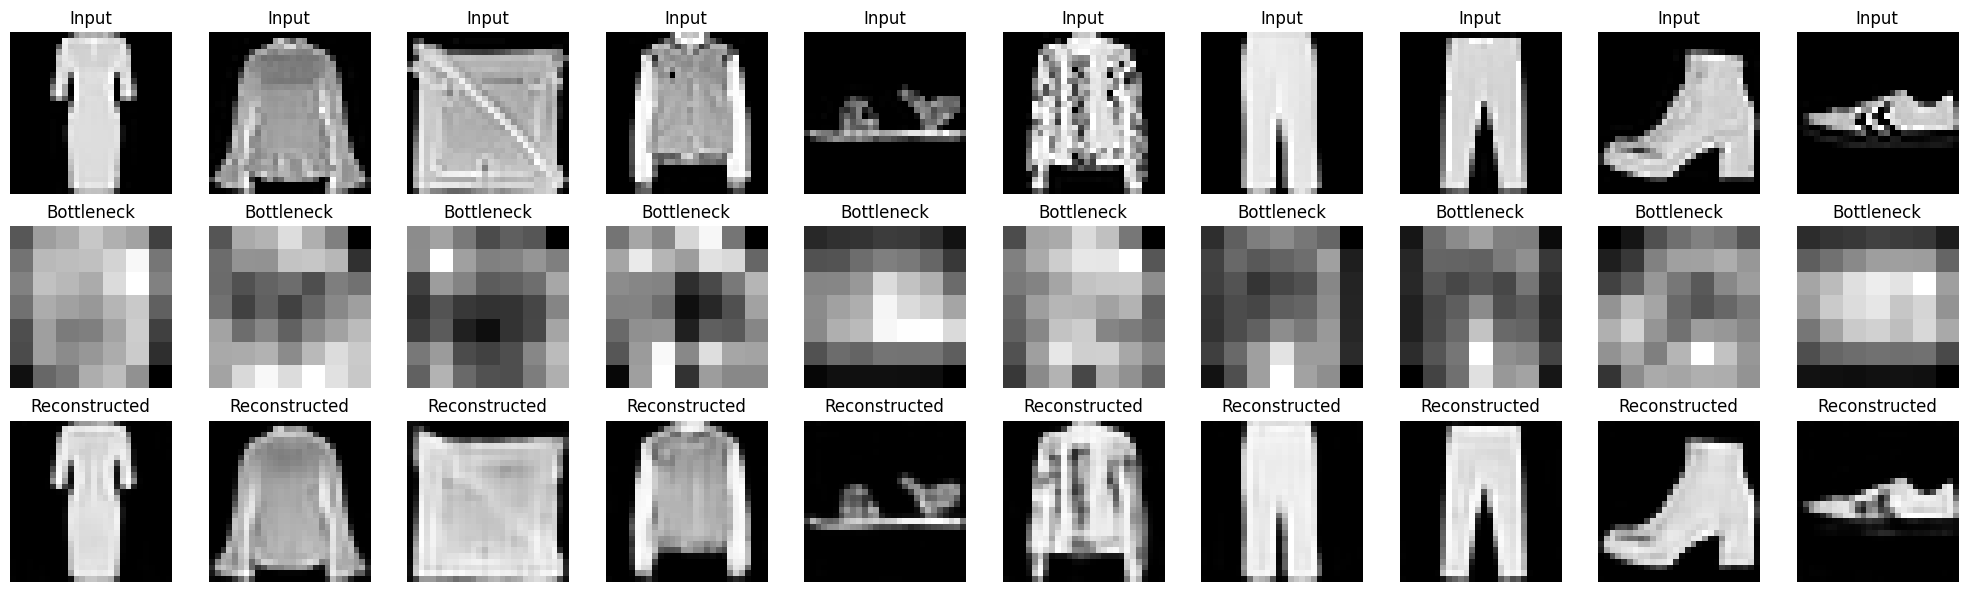

In [60]:
encoder_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('batch_normalization_4').output)
sample_indices = np.random.choice(test_data.shape[0], 10, replace=False)
sample_data = test_data[sample_indices]
bottleneck_representations = encoder_model.predict(sample_data)
reconstructed_images = autoencoder.predict(sample_data)

plt.figure(figsize=(20, 6))

for i in range(10):
    ax = plt.subplot(3, 10, i + 1)
    plt.imshow(sample_data[i].reshape(28, 28), cmap='gray')
    plt.title('Input')
    plt.axis('off')

    ax = plt.subplot(3, 10, i + 1 + 10)
    bottleneck_img = np.mean(bottleneck_representations[i], axis=-1)
    plt.imshow(bottleneck_img, cmap='gray')
    plt.title('Bottleneck')
    plt.axis('off')

    ax = plt.subplot(3, 10, i + 1 + 20)
    plt.imshow(reconstructed_images[i].reshape(28, 28), cmap='gray')
    plt.title('Reconstructed')
    plt.axis('off')

plt.tight_layout()
plt.show()